# Walmart RTO Hackathon

## 1. Data Cleaning

The first step is to clean the data. After investigation, we found some problems in the dataset and took the following actions:

### Animal Data
- Duplicates: there are rows that are identical, Drop Duplicates
- Split intake_date: we want to get three additional variables - year, month, day **DONE**
- Animal_ID: we need to generate a new vairable to indicate each unique pet. It could simply be the same as row number
- Variable `species`:
    - malformat: DOG and Dog **DONE**
    - There are not only dogs and cats. But other pets (include horse, other, pig...) take only a small proportion. Do we categorize them all to OTHER, or Drop them?
    - Missing for San Diego shelter
- Variable `distance_miles`:
    - No missing except in San Diego shelter
    - But some entries are too large and suspicious. We could set a limit, eg. `distance_miles`>100/500/1000.
    - Should we take the long-distance/interstate travel as some pattern, or error of data, or mixture?
- Row `shelter_id == San Diego`:
    - no information about `Species`, `found_lat`, `found_lng`, `outcome_lat`, `outcome_lng`
    - some missing in `distance_miles`
        - For the rows where `distance_miles` are missing, address is too general so we could not get info about lng and lat
        - For the rest where `distance_miles` are not missing, can we get the lng and lat values based on the address?
        
        
### Shelter Data
- Not too much to work with this dataset I think. For the missings of `annual_intake`, we could replace them by the mean of `annual_intake` in previous years. If those variables are significant in our model, we then need to emphasize the limit of this approach. Otherwise its fine.
- Then we could use shelter_id the merge `animial_data` and `shelter_data`.

In [10]:
import pandas as pd

# import data

file_path = "C:/Users/Soli1/Downloads/ampa_wmt_rto_hackathon_july-22_data.xlsx"
animal_data = pd.read_excel(file_path, sheet_name="animal_data")
shelter_data = pd.read_excel(file_path, sheet_name="shelter_data")

In [11]:
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# take a look at the first 5 observations
animal_data.head()

,shelter_id,intake_date,Species,found_lng,found_lat,outcome_lng,outcome_lat,distance_miles,found_address,outcome_address
0,Rochester,2021-01-28,Dog,-77.633991,43.177237,-77.634618,43.178387,0.085445,158 Glenwood ave Rochester 14613,54 Tacoma Street Rochester NY 14613
1,Rochester,2021-01-30,Dog,-77.599173,43.185495,-77.583367,43.171650,1.245466,1094 HUDSON AVE 14621 Rochester 14621,31 CROMBIE ST Rochester NY 14605
2,Rochester,2021-01-30,Dog,-77.617074,43.241926,-77.615373,43.249483,0.528722,17 Hughes pl Rochester 14608,4313 LAKE AVE Rochester NY 14612
3,Rochester,2021-02-01,Dog,-77.643231,43.180933,-77.645970,43.179665,0.163735,DRIVING PK and 2 CANARY ST. Rochester 14608,1 CANARY ST Rochester NY 14613
4,Rochester,2021-02-03,Dog,-77.650684,43.143780,-77.653187,43.145435,0.170467,74 Thurston Rd Rochester 14608,216 DEPEW Street Rochester NY 14611


## 2. Summary Statistices


In [4]:
#conda install pytorch-cpu torchvision-cpu -c pytorch

In [5]:
#conda activate pytorch_env

In [6]:
#!pip install torchvision

In [7]:
#conda install cudnn

In [1]:
#import torch
#import torchvision.transforms as T
#from torchvision.io import read_image
#import torchvision

In [10]:
animal_data.shape
# 10 variables, 23080 observations

(23080, 10)

In [11]:
# list all variables
animal_data.columns

Index(['shelter_id', 'intake_date', 'Species', 'found_lng', 'found_lat',
       'outcome_lng', 'outcome_lat', 'distance_miles', 'found_address',
       'outcome_address'],
      dtype='object')

In [12]:
animal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23080 entries, 0 to 23079
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   shelter_id       23080 non-null  object        
 1   intake_date      23080 non-null  datetime64[ns]
 2   Species          19966 non-null  object        
 3   found_lng        19966 non-null  float64       
 4   found_lat        19966 non-null  float64       
 5   outcome_lng      19966 non-null  float64       
 6   outcome_lat      19966 non-null  float64       
 7   distance_miles   23054 non-null  float64       
 8   found_address    23080 non-null  object        
 9   outcome_address  23068 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 1.8+ MB


In [13]:
animal_data.describe()

,found_lng,found_lat,outcome_lng,outcome_lat,distance_miles
count,19966.000000,19966.000000,19966.000000,19966.000000,23054.000000
mean,-102.310446,33.293523,-102.317015,33.286317,7.352016
std,11.093117,2.598450,11.076127,2.570052,92.484657
min,-122.299066,-22.906847,-122.456421,25.927541,0.000000
25%,-111.033083,32.279603,-111.037122,32.280073,0.102528
50%,-96.897800,32.740239,-96.906801,32.739913,0.412854
75%,-96.714288,33.840206,-96.712254,33.843464,2.305908
max,-43.172897,53.933271,-77.173657,43.319909,4998.633934


In [14]:
# number of animals in each shelter
shelter_count = animal_data['shelter_id'].value_counts()
print(shelter_count)

Dallas       7792
Tucson       4402
Las Vegas    3481
San Diego    3114
Atlanta      1796
Mcallen       751
Pasco         601
Oakland       310
Rochester     302
Madera        288
Fresno        243
Name: shelter_id, dtype: int64


<AxesSubplot:>

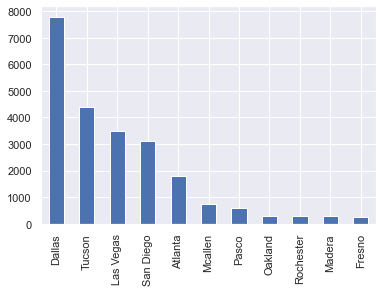

In [15]:
shelter_count.plot(kind="bar")

In [16]:
animal_data['intake_year'] = animal_data['intake_date'].dt.year
animal_data['intake_month'] = animal_data['intake_date'].dt.month
animal_data['intake_day'] = animal_data['intake_date'].dt.day
animal_data.iloc[0:2, [1, -3, -2, -1]]

,intake_date,intake_year,intake_month,intake_day
0,2021-01-28,2021,1,28
1,2021-01-30,2021,1,30


In [17]:
# missing values
# Get names of columns with missing values
cols_with_missing = [col for col in animal_data.columns if animal_data[col].isnull().any()]
print(cols_with_missing)

['Species', 'found_lng', 'found_lat', 'outcome_lng', 'outcome_lat', 'distance_miles', 'outcome_address']


In [18]:
# number of each species
species_count_raw = animal_data['Species'].value_counts(dropna=False)
print(species_count_raw)
# We notice that DOG&Dog should be the same
# We also notice that there minor species (other than Dog and Cat)

DOG            11273
Dog             8344
NaN             3114
Cat              316
Other             27
Pig                2
Horse              2
Pet Reptile        1
Rabbit             1
Name: Species, dtype: int64


<AxesSubplot:>

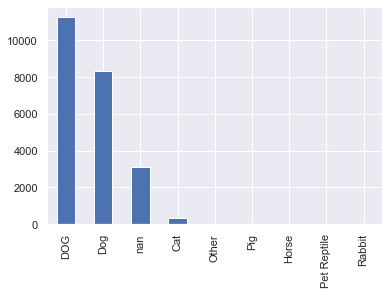

In [19]:
species_count_raw.plot(kind="bar")

In [20]:
# fix malformat
animal_data['Species'] = animal_data['Species'].str.title()
species_count = animal_data['Species'].value_counts(dropna=False)
print(species_count)
# I do not think we can do anything about the missing values (NaN) here

Dog            19617
NaN             3114
Cat              316
Other             27
Pig                2
Horse              2
Pet Reptile        1
Rabbit             1
Name: Species, dtype: int64


In [21]:
animal_data['distance_miles'].isnull().value_counts()
# only 26 missing and all in San Diego, we could simply drop them
animal_data['distance_miles']

0        0.085445
1        1.245466
2        0.528722
3        0.163735
4        0.170467
           ...   
23075    1.536071
23076    0.046022
23077    0.090819
23078    0.124132
23079    9.428101
Name: distance_miles, Length: 23080, dtype: float64

In [22]:
animal_data_drop = animal_data.drop_duplicates(ignore_index=True)

In [ ]:
#animal_data_drop

In [23]:
# Now work on another dataset
shelter_data.head(11)

,shelter_id,annual_intake_2019,annual_intake_2020,annual_intake_2021,jurisdiction_size_sq_km,justidiction_state,jurisdiction_region,jurisdiction_pop_size,jurisdiction_pop_density_person_per_sq_km
0,Rochester,3867,2732.0,2677.0,3541,NY,Monroe County,741770,209.480373
1,Oakland,6188,5234.0,7613.0,1914,CA,Alameda County,1682353,878.972309
2,Fresno,8001,6246.0,6634.0,15568,CA,Fresno County,999101,64.176580
3,Mcallen,21815,15511.0,15283.0,4100,TX,Hidalgo County,868707,211.879756
4,Tucson,27064,17547.0,23940.0,23799,AZ,Pima County,1043433,43.843565
5,Madera,5166,NaN,NaN,5576,CA,Madera County,156255,28.022776
6,Las Vegas,27922,17957.0,NaN,20878,NV,Clark County,2265461,108.509484
7,Dallas,40155,19594.0,18533.0,1992,TX,Dallas City,1304379,654.808735
8,San Diego,33555,31871.0,30803.0,11036,TX,San Diego County,3338000,302.464661
9,Pasco,9906,11370.0,6510.0,2250,FL,Pasco County,553947,246.198667


In [24]:
shelter_data.describe()

,annual_intake_2019,annual_intake_2020,annual_intake_2021,jurisdiction_size_sq_km,jurisdiction_pop_size,jurisdiction_pop_density_person_per_sq_km
count,11.000000,10.000000,9.000000,11.000000,1.100000e+01,11.000000
mean,17447.909091,13512.400000,13366.111111,8305.090909,1.247072e+06,348.838196
std,12993.836912,8805.288552,9431.010079,8254.371817,8.947956e+05,361.648338
min,3867.000000,2732.000000,2677.000000,702.000000,1.562550e+05,28.022776
25%,7094.500000,6450.000000,6634.000000,2121.000000,7.530760e+05,86.343032
50%,9906.000000,13440.500000,8302.000000,4100.000000,9.991010e+05,211.879756
75%,27493.000000,17854.500000,18533.000000,13302.000000,1.493366e+06,478.636698
max,40155.000000,31871.000000,30803.000000,23799.000000,3.338000e+06,1088.863248


In [25]:
shelter_data.loc[5] = shelter_data.loc[5].fillna(method='ffill')
mean_Las_Vegas = shelter_data.loc[6, ['annual_intake_2019','annual_intake_2020']].mean()
print(mean_Las_Vegas)
shelter_data.loc[6] = shelter_data.loc[6].fillna(value=mean_Las_Vegas)
shelter_data.head(11)

22939.5


,shelter_id,annual_intake_2019,annual_intake_2020,annual_intake_2021,jurisdiction_size_sq_km,justidiction_state,jurisdiction_region,jurisdiction_pop_size,jurisdiction_pop_density_person_per_sq_km
0,Rochester,3867,2732.0,2677.0,3541,NY,Monroe County,741770,209.480373
1,Oakland,6188,5234.0,7613.0,1914,CA,Alameda County,1682353,878.972309
2,Fresno,8001,6246.0,6634.0,15568,CA,Fresno County,999101,64.176580
3,Mcallen,21815,15511.0,15283.0,4100,TX,Hidalgo County,868707,211.879756
4,Tucson,27064,17547.0,23940.0,23799,AZ,Pima County,1043433,43.843565
5,Madera,5166,5166.0,5166.0,5576,CA,Madera County,156255,28.022776
6,Las Vegas,27922,17957.0,22939.5,20878,NV,Clark County,2265461,108.509484
7,Dallas,40155,19594.0,18533.0,1992,TX,Dallas City,1304379,654.808735
8,San Diego,33555,31871.0,30803.0,11036,TX,San Diego County,3338000,302.464661
9,Pasco,9906,11370.0,6510.0,2250,FL,Pasco County,553947,246.198667


In [26]:
# merge two datasets
merged_data = animal_data.merge(shelter_data, how='left', left_on='shelter_id', right_on='shelter_id')
# or
#result2 = animal_data.merge(shelter_data, on='shelter_id')

In [27]:
merged_data.describe()

,found_lng,found_lat,outcome_lng,outcome_lat,distance_miles,intake_year,intake_month,intake_day,annual_intake_2019,annual_intake_2020,annual_intake_2021,jurisdiction_size_sq_km,jurisdiction_pop_size,jurisdiction_pop_density_person_per_sq_km
count,19966.000000,19966.000000,19966.000000,19966.000000,23054.000000,23080.000000,23080.000000,23080.000000,23080.000000,23080.000000,23080.000000,23080.000000,2.308000e+04,23080.000000
mean,-102.310446,33.293523,-102.317015,33.286317,7.352016,2020.115901,6.069021,15.125607,29352.262738,18556.829549,20023.169259,10401.692374,1.578379e+06,400.214946
std,11.093117,2.598450,11.076127,2.570052,92.484657,2.229392,3.631739,9.081604,10822.295982,6778.940977,6889.394868,9339.179071,8.380103e+05,324.623771
min,-122.299066,-22.906847,-122.456421,25.927541,0.000000,2017.000000,1.000000,1.000000,3867.000000,2732.000000,2677.000000,702.000000,1.562550e+05,28.022776
25%,-111.033083,32.279603,-111.037122,32.280073,0.102528,2019.000000,3.000000,7.000000,27064.000000,17547.000000,18533.000000,1992.000000,1.043433e+06,108.509484
50%,-96.897800,32.740239,-96.906801,32.739913,0.412854,2019.000000,6.000000,15.000000,27922.000000,17957.000000,18533.000000,4100.000000,1.304379e+06,302.464661
75%,-96.714288,33.840206,-96.712254,33.843464,2.305908,2021.000000,9.000000,23.000000,40155.000000,19594.000000,23940.000000,20878.000000,2.265461e+06,654.808735
max,-43.172897,53.933271,-77.173657,43.319909,4998.633934,2029.000000,12.000000,31.000000,40155.000000,31871.000000,30803.000000,23799.000000,3.338000e+06,1088.863248


In [28]:
#output_path = "/Users/xuezhansun/Desktop/Hackathon"
merged_data.to_excel("merged_data.xlsx")

<AxesSubplot:xlabel='found_lng', ylabel='found_lat'>

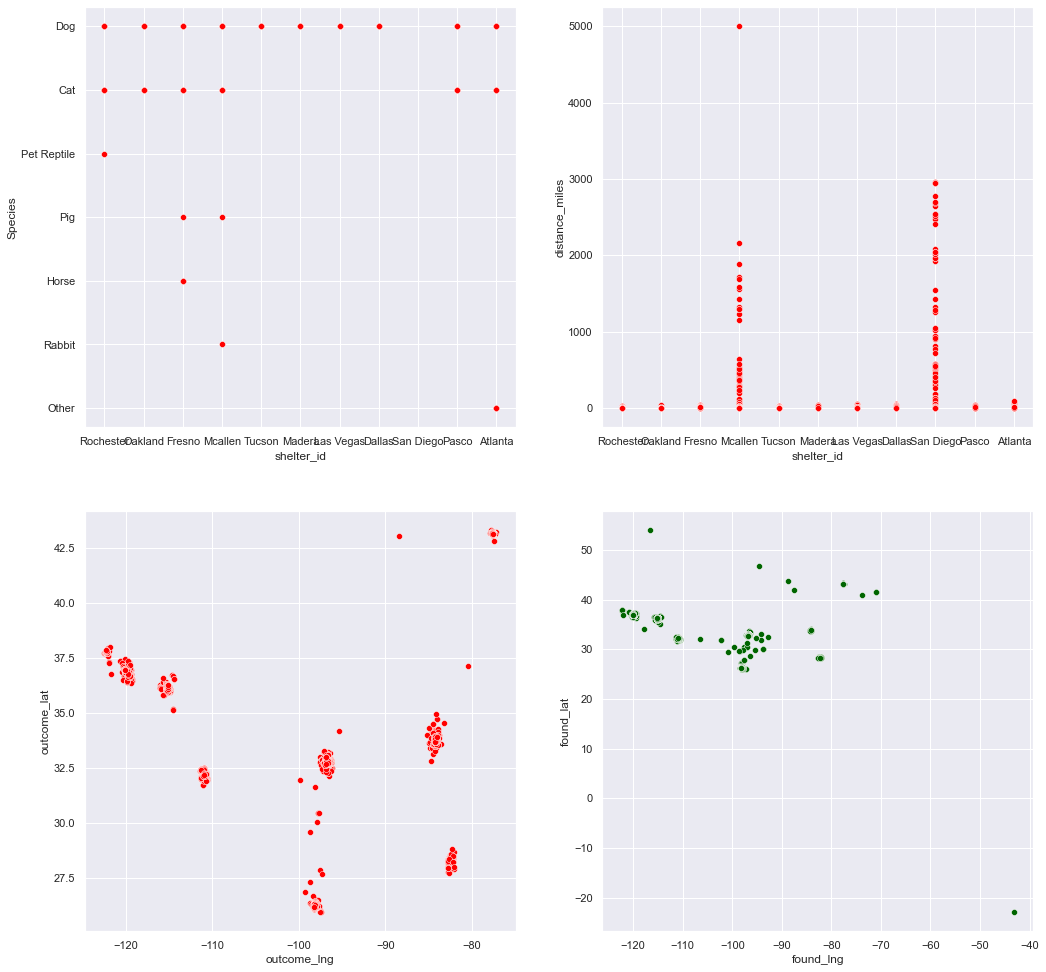

In [34]:
# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 17),
                       gridspec_kw={
                           'width_ratios': [3, 3],
                           'height_ratios': [3, 3],
                       'wspace': 0.2,
                       'hspace': 0.2})
 
sns.scatterplot(data=animal_data, x='shelter_id', y ='Species', ax=ax[0, 0], color="red")
sns.scatterplot(data=animal_data, x='shelter_id', y ='distance_miles', ax=ax[0, 1], color="red")
sns.scatterplot(data=merged_data, x='outcome_lng', y ='outcome_lat', ax=ax[1, 0], color="red")
sns.scatterplot(data=merged_data, x='found_lng', y ='found_lat', ax=ax[1, 1], color="darkgreen")